In [50]:
import sys
import warnings
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
# from shapely.geometry import Polygon, LineString, Point  # 공간 정보 처리

warnings.filterwarnings("ignore")

In [4]:
print("Python version :", sys.version)
print("Numpy version :", np.__version__)
print("Pandas version :", pd.__version__)
print("Geopandas version :", gpd.__version__)

Python version : 3.11.3 | packaged by Anaconda, Inc. | (main, May 15 2023, 15:41:31) [MSC v.1916 64 bit (AMD64)]
Numpy version : 1.26.2
Pandas version : 2.1.3
Geopandas version : 0.14.1


## 데이터 확인 및 전처리

In [25]:
df_train = pd.read_csv("./data/train.csv")

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


In [21]:
# 컬럼별 데이터 라벨 확인

df_train.nunique()

ID             39609
사고일시           18057
요일                 7
기상상태               6
시군구              199
도로형태              11
노면상태               6
사고유형               3
사고유형 - 세부분류       14
법규위반              11
가해운전자 차종          12
가해운전자 성별           3
가해운전자 연령          89
가해운전자 상해정도         6
피해운전자 차종          13
피해운전자 성별           3
피해운전자 연령          97
피해운전자 상해정도         6
사망자수               3
중상자수               7
경상자수              18
부상자수               9
ECLO              46
dtype: int64

In [26]:
# 테스트 데이터 데이터 확인

df_test = pd.read_csv("./data/test.csv")

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    10963 non-null  object
dtypes: object(8)
memory usage: 685.3+ KB


In [24]:
# 테스트 데이터 라벨 확인

df_test.nunique()

ID      10963
사고일시     5548
요일          7
기상상태        5
시군구       192
도로형태       11
노면상태        6
사고유형        3
dtype: int64

In [29]:
# train-test 중 겹치는 컬럼의 데이터 라벨 확인

col_test = df_test.columns[1:]

for c in col_test : 
    print(c+"의 train unique")
    print(sorted(df_train[c].unique().tolist()))
    print("-----------------------")
    print(c+"의 test unique")
    print(sorted(df_test[c].unique().tolist()))
    print("********************")


# 시군구의 경우 test에 존재하는 값이 train에 전부 존재하는지 확인

사고일시의 train unique
['2019-01-01 00', '2019-01-01 01', '2019-01-01 02', '2019-01-01 04', '2019-01-01 05', '2019-01-01 06', '2019-01-01 10', '2019-01-01 11', '2019-01-01 14', '2019-01-01 18', '2019-01-01 19', '2019-01-01 20', '2019-01-01 22', '2019-01-02 01', '2019-01-02 02', '2019-01-02 07', '2019-01-02 08', '2019-01-02 10', '2019-01-02 11', '2019-01-02 13', '2019-01-02 14', '2019-01-02 15', '2019-01-02 16', '2019-01-02 17', '2019-01-02 18', '2019-01-02 19', '2019-01-02 20', '2019-01-02 22', '2019-01-02 23', '2019-01-03 00', '2019-01-03 02', '2019-01-03 03', '2019-01-03 05', '2019-01-03 07', '2019-01-03 08', '2019-01-03 10', '2019-01-03 11', '2019-01-03 12', '2019-01-03 13', '2019-01-03 14', '2019-01-03 15', '2019-01-03 17', '2019-01-03 18', '2019-01-03 19', '2019-01-03 20', '2019-01-03 21', '2019-01-03 22', '2019-01-03 23', '2019-01-04 00', '2019-01-04 01', '2019-01-04 04', '2019-01-04 05', '2019-01-04 06', '2019-01-04 07', '2019-01-04 08', '2019-01-04 10', '2019-01-04 11', '2019-01-04

In [36]:
uni_city = df_test["시군구"].unique().tolist()

len_city_test = len(uni_city)

len_city_train = len(df_train[df_train["시군구"].isin(uni_city)]["시군구"].unique())

if len_city_test == len_city_train : 
    print("test data의 시군구 값은 train data에 전부 속합니다.")

test data의 시군구 값은 train data에 전부 속합니다.


In [27]:
# 사고 일시 object -> datetime

df_train["사고일시"] = pd.to_datetime(df_train["사고일시"], format="%Y-%m-%d %H")
df_test["사고일시"] = pd.to_datetime(df_test["사고일시"], format="%Y-%m-%d %H")

print(df_train["사고일시"].dtypes)
print(df_test["사고일시"].dtypes)

datetime64[ns]
datetime64[ns]


In [5]:
# # 숫자 데이터이지만 object인 변수의 타입을 변경

# df_train[["사망자수",'중상자수','경상자수','부상자수',"ECLO"]] = df_train[["사망자수",'중상자수','경상자수','부상자수',"ECLO"]].astype(int)

# df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           39609 non-null  object        
 1   사고일시         39609 non-null  datetime64[ns]
 2   요일           39609 non-null  object        
 3   기상상태         39609 non-null  object        
 4   시군구          39609 non-null  object        
 5   도로형태         39609 non-null  object        
 6   노면상태         39609 non-null  object        
 7   사고유형         39609 non-null  object        
 8   사고유형 - 세부분류  39609 non-null  object        
 9   법규위반         39609 non-null  object        
 10  가해운전자 차종     39609 non-null  object        
 11  가해운전자 성별     39609 non-null  object        
 12  가해운전자 연령     39609 non-null  object        
 13  가해운전자 상해정도   39609 non-null  object        
 14  피해운전자 차종     38618 non-null  object        
 15  피해운전자 성별     38618 non-null  object        
 16  피해운전

In [46]:
# 컬럼별 결측치 갯수 확인

df_train.isnull().sum()

ID               0
사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

결측치의 대부분이 피해 운전자이므로, 결측치가 존재하는 데이터의 사고 유형 등을 확인

In [52]:
df_train_null = df_train[df_train["피해운전자 차종"].isnull()]

print("null인 데이터의 사고 종류 :",df_train_null["사고유형"].unique())
print("null인 데이터의 상해 정도 종류 :",df_train_null["가해운전자 상해정도"].unique())

# 차량 단독으로 일어난 사고이므로 피해자가 없음, 차량 단독이지만 상해 종류는 다양

null인 데이터의 사고 종류 : ['차량단독']
null인 데이터의 상해 정도 종류 : ['중상' '경상' '상해없음' '부상신고' '사망' '기타불명']


In [53]:
# '차량 단독'이 전체 데이터 중 어느 정도 비율을 차지하는지 확인

df_train["사고유형"].value_counts()

사고유형
차대차     31785
차대사람     6833
차량단독      991
Name: count, dtype: int64

차량 단독의 전체 개수가 null 값인 사고 유형의 갯수와 일치하므로, 차량 단독 데이터를 제거할 수 없고 결측치 처리 필요

In [28]:
# 피해 운전자 관련 데이터의 label 확인

pihae = ['피해운전자 차종','피해운전자 성별','피해운전자 연령','피해운전자 상해정도']

for i in range(4) : 
    print(df_train[pihae[i]].unique())
    print("--------------------------")


# null 값을 '기타불명', '미분류' 등으로 대체

['보행자' '승용' '자전거' '승합' nan '이륜' '화물' '개인형이동수단(PM)' '사륜오토바이(ATV)' '특수'
 '원동기' '기타불명' '건설기계' '농기계']
--------------------------
['여' '남' nan '기타불명']
--------------------------
['70세' '61세' '38세' '36세' '52세' '35세' '76세' '53세' '62세' '42세' '60세' '69세'
 '31세' '23세' nan '57세' '17세' '54세' '55세' '64세' '41세' '44세' '58세' '45세'
 '30세' '59세' '34세' '68세' '32세' '21세' '56세' '18세' '37세' '39세' '27세' '65세'
 '43세' '12세' '75세' '4세' '71세' '40세' '48세' '14세' '19세' '66세' '63세' '50세'
 '20세' '67세' '26세' '22세' '47세' '16세' '28세' '46세' '51세' '29세' '33세' '24세'
 '79세' '80세' '74세' '78세' '72세' '49세' '73세' '5세' '13세' '77세' '9세' '86세'
 '15세' '84세' '25세' '82세' '10세' '8세' '85세' '7세' '11세' '88세' '미분류' '87세'
 '83세' '90세 이상' '3세' '81세' '6세' '89세' '2세' '1세' '91세' '90세' '93세' '94세'
 '92세' '98세 이상']
--------------------------
['중상' '경상' '상해없음' nan '부상신고' '사망' '기타불명']
--------------------------


In [29]:
# 결측치 채움

fill = ["기타불명", "기타불명", "미분류", "기타불명"]

for i in range(4) : 
    df_train[pihae[i]].fillna(fill[i], inplace=True)

df_train.isnull().sum()

ID             0
사고일시           0
요일             0
기상상태           0
시군구            0
도로형태           0
노면상태           0
사고유형           0
사고유형 - 세부분류    0
법규위반           0
가해운전자 차종       0
가해운전자 성별       0
가해운전자 연령       0
가해운전자 상해정도     0
피해운전자 차종       0
피해운전자 성별       0
피해운전자 연령       0
피해운전자 상해정도     0
사망자수           0
중상자수           0
경상자수           0
부상자수           0
ECLO           0
dtype: int64

### 외부 데이터 불러오기

In [30]:
# cctv 데이터

cctv = pd.read_csv("./data/external_open/대구 CCTV 정보.csv", encoding='cp949')

cctv.info()
# cctv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  1065 non-null   object 
 1   시도명            1065 non-null   object 
 2   시군구명           1065 non-null   object 
 3   도로종류           1065 non-null   object 
 4   도로노선번호         288 non-null    object 
 5   도로노선명          1065 non-null   object 
 6   도로노선방향         1065 non-null   int64  
 7   소재지도로명주소       905 non-null    object 
 8   소재지지번주소        1063 non-null   object 
 9   위도             1065 non-null   float64
 10  경도             1065 non-null   float64
 11  설치장소           1065 non-null   object 
 12  단속구분           1065 non-null   int64  
 13  제한속도           1065 non-null   int64  
 14  단속구간위치구분       53 non-null     float64
 15  과속단속구간길이       26 non-null     float64
 16  보호구역구분         893 non-null    float64
 17  설치연도           1065 non-null   float64
dtypes: float

In [9]:
cctv[["단속구분", "제한속도"]].value_counts().sort_index(ascending=False).to_frame()

count
단속구분 제한속도       
99   100      16
     80       25
     60        2
     50        4
     40        2
     30        2
4    0       232
2    80        3
     70       13
     60      126
     50      218
     40       67
     30      148
1    110       1
     100       3
     80        4
     70        9
     60       59
     50       52
     40       11
     30       68

보통 제한 속도를 보면서 운전을 하는 것이 아니라 cctv가 있을 때 속도를 줄이므로,  
단속 구분과 제한 속도는 의미가 없고 행정 구역별 갯수가 유의미할 것으로 판단

In [31]:
# 보안등 데이터

light = pd.read_csv("./data/external_open/대구 보안등 정보.csv", encoding='cp949')

light.info()
# light.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71913 entries, 0 to 71912
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   보안등위치명    71913 non-null  object 
 1   설치개수      71913 non-null  int64  
 2   소재지도로명주소  34646 non-null  object 
 3   소재지지번주소   71913 non-null  object 
 4   위도        43602 non-null  float64
 5   경도        43602 non-null  float64
 6   설치연도      29397 non-null  float64
 7   설치형태      35373 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 4.4+ MB


In [32]:
# 어린이 보호 구역 데이터

child = pd.read_csv("./data/external_open/대구 어린이 보호 구역 정보.csv", encoding='cp949')

child.info()
# child.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설종류      640 non-null    object 
 1   대상시설명     640 non-null    object 
 2   소재지도로명주소  640 non-null    object 
 3   소재지지번주소   555 non-null    object 
 4   위도        640 non-null    float64
 5   경도        640 non-null    float64
 6   관리기관명     640 non-null    object 
 7   관할경찰서명    640 non-null    object 
 8   CCTV설치여부  640 non-null    object 
 9   CCTV설치대수  465 non-null    float64
 10  보호구역도로폭   320 non-null    object 
 11  데이터기준일자   640 non-null    object 
dtypes: float64(3), object(9)
memory usage: 60.1+ KB


In [33]:
# cctv 설치여부 Y -> 1, N -> 0으로 변경

child["CCTV설치여부"].replace({"Y":1, "N":0}, inplace=True)

child["CCTV설치여부"].unique()

array([1, 0], dtype=int64)

In [34]:
data_sch = child["대상시설명"].value_counts()

data_sch

대상시설명
죽곡어린이집         2
화원초등           2
죽곡초등           2
천내초등           2
하빈면초등          2
              ..
관문초등           1
대구과학대학부설유치원    1
달산초등           1
다솜유치원          1
동화나라어린이집       1
Name: count, Length: 538, dtype: int64

In [37]:
child[child["대상시설명"]=="화원초등"]

# 동일한 데이터가 2개

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
95,초등학교,화원초등,대구광역시 달성군 화원읍 비슬로 2580,대구광역시 달성군 화원읍 천내리 417,35.803331,128.499624,대구광역시 달성군청,달성경찰서,1,2.0,NaN,2019-09-10
194,초등학교,화원초등,대구광역시 달성군 화원읍 비슬로 2580,대구광역시 달성군 화원읍 천내리 417,35.803331,128.499624,대구광역시 달성군청,달성경찰서,1,2.0,NaN,2019-09-10


In [38]:
date_date_child = child[["대상시설명","데이터기준일자"]].value_counts()

date_date_child

# 이름은 같지만 데이터기준일자가 다른 데이터가 존재

대상시설명     데이터기준일자   
죽곡초교병설    2019-09-10    2
자연숲유치원    2019-09-10    2
동곡초등학교병설  2019-09-10    2
천내초등      2019-09-10    2
천내어린이집    2019-09-10    2
                       ..
무열대유치원    2019-12-27    1
무산유치원     2020-01-14    1
모란어린이집    2019-12-27    1
명지어린이집    2020-01-14    1
효신초교      2020-01-14    1
Name: count, Length: 541, dtype: int64

In [39]:
print("대상시설명과 데이터기준일자에 따른 데이터 총합 =", date_date_child.sum())

대상시설명과 데이터기준일자에 따른 데이터 총합 = 640


In [35]:
child_dr = child.drop_duplicates(subset=["대상시설명","데이터기준일자"], keep="first")

child_dr[["대상시설명","데이터기준일자"]].value_counts()

대상시설명    데이터기준일자   
DGB어린이집  2019-12-27    1
영선초등학교   2020-03-23    1
옥빛유치원    2019-09-10    1
예지원어린이집  2019-12-27    1
예일유치원    2019-12-17    1
                      ..
만촌초등학교   2019-12-27    1
만촌어린이집   2019-12-27    1
마리아유치원   2019-12-27    1
리오바어린이집  2019-12-27    1
효신초교     2020-01-14    1
Name: count, Length: 541, dtype: int64

In [17]:
child_dr[child_dr["대상시설명"]=="꿈나무어린이집"]

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
509,어린이집,꿈나무어린이집,대구광역시 수성구 들안로2안길 27-15(두산동),대구광역시 수성구 두산동 159-1,35.832741,128.619288,대구광역시 수성구,수성경찰서,1,NaN,NaN,2019-12-27
639,어린이집,꿈나무어린이집,대구광역시 중구 남산로7길 35,대구광역시 중구 남산동 2508-2,35.858483,128.580584,대구광역시 중구청,대구광역시 중부경찰서,1,4.0,7~11,2019-06-01


이름이 같고 주소가 다른 어린이집이 존재

In [40]:
print("중복을 제거한 대상시설명과 데이터기준일자에 따른 데이터 총합 =", child_dr[["대상시설명","데이터기준일자"]].value_counts().sum())

중복을 제거한 대상시설명과 데이터기준일자에 따른 데이터 총합 = 541


어린이 보호 구역에 cctv 여부는 중요할 것으로 판단(cctv가 존재할 때 속도를 줄일 것이기에).

In [36]:
# 주차장 데이터

parking = pd.read_csv("./data/external_open/대구 주차장 정보.csv", encoding='cp949')

parking.info()
# parking.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   주차장관리번호      871 non-null    object 
 1   주차장명         871 non-null    object 
 2   주차장구분        871 non-null    object 
 3   주차장유형        871 non-null    object 
 4   소재지도로명주소     674 non-null    object 
 5   소재지지번주소      775 non-null    object 
 6   주차구획수        871 non-null    int64  
 7   급지구분         871 non-null    int64  
 8   부제시행구분       871 non-null    object 
 9   운영요일         871 non-null    object 
 10  평일운영시작시각     871 non-null    object 
 11  평일운영종료시각     871 non-null    object 
 12  토요일운영시작시각    871 non-null    object 
 13  토요일운영종료시각    871 non-null    object 
 14  공휴일운영시작시각    871 non-null    object 
 15  공휴일운영종료시각    871 non-null    object 
 16  요금정보         871 non-null    object 
 17  주차기본시간       871 non-null    int64  
 18  주차기본요금       871 non-null    int64  
 19  추가단위시간  

In [37]:
# 각 외부 데이터의 주소를 대구광역시-구-동 까지만 표현

cctv["주소_수정"] = cctv["소재지지번주소"].str.extract(r'(대구광역시\s[ㄱ-힣]+\s[ㄱ-힣]+)\s')
light["주소_수정"] = light["소재지지번주소"].str.extract(r'(대구광역시\s[ㄱ-힣]+\s[ㄱ-힣]+)\s')
child_dr["주소_수정"] = child_dr["소재지지번주소"].str.extract(r'(대구광역시\s[ㄱ-힣]+\s[ㄱ-힣]+)\s')
parking["주소_수정"] = parking["소재지지번주소"].str.extract(r'(대구광역시\s[ㄱ-힣]+\s[ㄱ-힣]+)\s')

child_dr["주소_수정"]

0      대구광역시 남구 대명동
1      대구광역시 남구 이천동
2      대구광역시 남구 대명동
3      대구광역시 남구 대명동
4      대구광역시 남구 대명동
           ...     
635    대구광역시 중구 남산동
636    대구광역시 중구 봉산동
637    대구광역시 중구 남산동
638    대구광역시 중구 남산동
639    대구광역시 중구 남산동
Name: 주소_수정, Length: 541, dtype: object

In [38]:
# 주소별로 지역별 전체 cctv 갯수 파악

gb_cctv = cctv.groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

gb_cctv.index.rename("",inplace=True)

gb_cctv = gb_cctv.to_frame()

gb_cctv.reset_index(level=0,inplace=True)

gb_cctv.columns = ["주소_수정", "주소별 cctv 수"]

gb_cctv

,주소_수정,주소별 cctv 수
0,대구광역시 남구 대명동,62
1,대구광역시 달성군 다사읍,44
2,대구광역시 달성군 화원읍,33
3,대구광역시 달서구 용산동,33
4,대구광역시 달서구 상인동,30
...,...,...
133,대구광역시 북구 조야동,1
134,대구광역시 북구 학정동,1
135,대구광역시 서구 상리동,1
136,대구광역시 서구 원대동,1


In [39]:
# 주소별 어린이 보호구역 개수 파악

gb_child_dr = child_dr.groupby("주소_수정")[["주소_수정", "CCTV설치여부"]].agg({"주소_수정":["count"], "CCTV설치여부":["sum"]}).sort_index(axis=0, level=0)

gb_child_dr.columns = ["주소별 어린이 보호구역 수", "주소별 어린이 보호구역 cctv 수"]

gb_child_dr.reset_index(inplace=True)

gb_child_dr

,주소_수정,주소별 어린이 보호구역 수,주소별 어린이 보호구역 cctv 수
0,대구광역시 남구 대명동,26,26
1,대구광역시 남구 봉덕동,8,8
2,대구광역시 남구 이천동,6,6
3,대구광역시 달성군 가창면,4,0
4,대구광역시 달성군 구지면,3,1
5,대구광역시 달성군 논공읍,11,1
6,대구광역시 달성군 다사읍,30,1
7,대구광역시 달성군 옥포면,11,0
8,대구광역시 달성군 유가읍,6,0
9,대구광역시 달성군 하빈면,4,0


In [40]:
# 주소별 보안등 정보

gb_light = light.groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

gb_light.index.rename("",inplace=True)

gb_light = gb_light.to_frame()

gb_light.reset_index(level=0,inplace=True)

gb_light.columns = ["주소_수정", "주소별 보안등 수"]

gb_light

,주소_수정,주소별 보안등 수
0,대구광역시 남구 대명동,5253
1,대구광역시 동구 신암동,1995
2,대구광역시 중구 남산동,1474
3,대구광역시 남구 봉덕동,1395
4,대구광역시 달서구 송현동,1365
...,...,...
148,대구광역시 달성군 원교리,2
149,대구광역시 달성군 송촌리,1
150,대구광역시 동구 입석로,1
151,대구광역시 중구 삼덕동,1


In [41]:
# 데이터 합치기 

gbList = ["cctv", "child_dr", "light"]

# cnt = 1
for i in range(3) : 
    # print(cnt)
    
    if i == 0 :
        df_train_join = pd.merge(df_train, globals()["gb_"+gbList[i]], how="left", left_on="시군구", right_on="주소_수정")
    else : 
        df_train_join = pd.merge(df_train_join, globals()["gb_"+gbList[i]], how="left", left_on="시군구", right_on="주소_수정")

    # cnt+=1

df_train_join.drop(["주소_수정", "주소_수정_x", "주소_수정_y"], axis=1, inplace=True)

df_train_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   39609 non-null  object        
 1   사고일시                 39609 non-null  datetime64[ns]
 2   요일                   39609 non-null  object        
 3   기상상태                 39609 non-null  object        
 4   시군구                  39609 non-null  object        
 5   도로형태                 39609 non-null  object        
 6   노면상태                 39609 non-null  object        
 7   사고유형                 39609 non-null  object        
 8   사고유형 - 세부분류          39609 non-null  object        
 9   법규위반                 39609 non-null  object        
 10  가해운전자 차종             39609 non-null  object        
 11  가해운전자 성별             39609 non-null  object        
 12  가해운전자 연령             39609 non-null  object        
 13  가해운전자 상해정도           39609 non-

In [42]:
for i in range(3) : 
    # print(cnt)
    
    if i == 0 :
        df_test_join = pd.merge(df_test, globals()["gb_"+gbList[i]], how="left", left_on="시군구", right_on="주소_수정")
    else : 
        df_test_join = pd.merge(df_test_join, globals()["gb_"+gbList[i]], how="left", left_on="시군구", right_on="주소_수정")

    # cnt+=1

df_test_join.drop(["주소_수정", "주소_수정_x", "주소_수정_y"], axis=1, inplace=True)

df_test_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   10963 non-null  object        
 1   사고일시                 10963 non-null  datetime64[ns]
 2   요일                   10963 non-null  object        
 3   기상상태                 10963 non-null  object        
 4   시군구                  10963 non-null  object        
 5   도로형태                 10963 non-null  object        
 6   노면상태                 10963 non-null  object        
 7   사고유형                 10963 non-null  object        
 8   주소별 cctv 수           9747 non-null   float64       
 9   주소별 어린이 보호구역 수       5580 non-null   float64       
 10  주소별 어린이 보호구역 cctv 수  5580 non-null   float64       
 11  주소별 보안등 수            7584 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 1.0+ MB


In [43]:
# 결측치를 전부 0으로 처리

df_train_join.fillna(0, axis=1, inplace=True)

df_test_join.fillna(0, axis=1, inplace=True)

print(df_train_join.isnull().sum())
print(df_test_join.isnull().sum())

ID                     0
사고일시                   0
요일                     0
기상상태                   0
시군구                    0
도로형태                   0
노면상태                   0
사고유형                   0
사고유형 - 세부분류            0
법규위반                   0
가해운전자 차종               0
가해운전자 성별               0
가해운전자 연령               0
가해운전자 상해정도             0
피해운전자 차종               0
피해운전자 성별               0
피해운전자 연령               0
피해운전자 상해정도             0
사망자수                   0
중상자수                   0
경상자수                   0
부상자수                   0
ECLO                   0
주소별 cctv 수             0
주소별 어린이 보호구역 수         0
주소별 어린이 보호구역 cctv 수    0
주소별 보안등 수              0
dtype: int64
ID                     0
사고일시                   0
요일                     0
기상상태                   0
시군구                    0
도로형태                   0
노면상태                   0
사고유형                   0
주소별 cctv 수             0
주소별 어린이 보호구역 수         0
주소별 어린이 보호구역 cctv 수    0
주소별 보안등 수              0
dtype: int64

## EDA

In [48]:
df_train_join[['사망자수','중상자수','경상자수','부상자수','ECLO','주소별 cctv 수','주소별 어린이 보호구역 수','주소별 어린이 보호구역 cctv 수','주소별 보안등 수']] = df_train_join[['사망자수','중상자수','경상자수','부상자수','ECLO','주소별 cctv 수','주소별 어린이 보호구역 수','주소별 어린이 보호구역 cctv 수','주소별 보안등 수']].astype(int)

df_train_join.dtypes

ID                     object
사고일시                   object
요일                     object
기상상태                   object
시군구                    object
도로형태                   object
노면상태                   object
사고유형                   object
사고유형 - 세부분류            object
법규위반                   object
가해운전자 차종               object
가해운전자 성별               object
가해운전자 연령               object
가해운전자 상해정도             object
피해운전자 차종               object
피해운전자 성별               object
피해운전자 연령               object
피해운전자 상해정도             object
사망자수                    int32
중상자수                    int32
경상자수                    int32
부상자수                    int32
ECLO                    int32
주소별 cctv 수              int32
주소별 어린이 보호구역 수          int32
주소별 어린이 보호구역 cctv 수     int32
주소별 보안등 수               int32
dtype: object

In [46]:
df_train_join.describe()

,사망자수,중상자수,경상자수,부상자수,ECLO,주소별 cctv 수,주소별 어린이 보호구역 수,주소별 어린이 보호구역 cctv 수,주소별 보안등 수
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000
mean,0.007776,0.262365,1.070085,0.126865,4.726704,13.139463,6.149638,5.152970,648.601479
std,0.090109,0.500845,0.992034,0.394670,3.207206,13.942405,8.277080,7.332679,1096.211387
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,3.000000,11.000000,0.000000,0.000000,306.000000
75%,0.000000,0.000000,1.000000,0.000000,6.000000,14.000000,9.000000,8.000000,876.000000
max,2.000000,6.000000,22.000000,10.000000,74.000000,62.000000,30.000000,26.000000,5253.000000


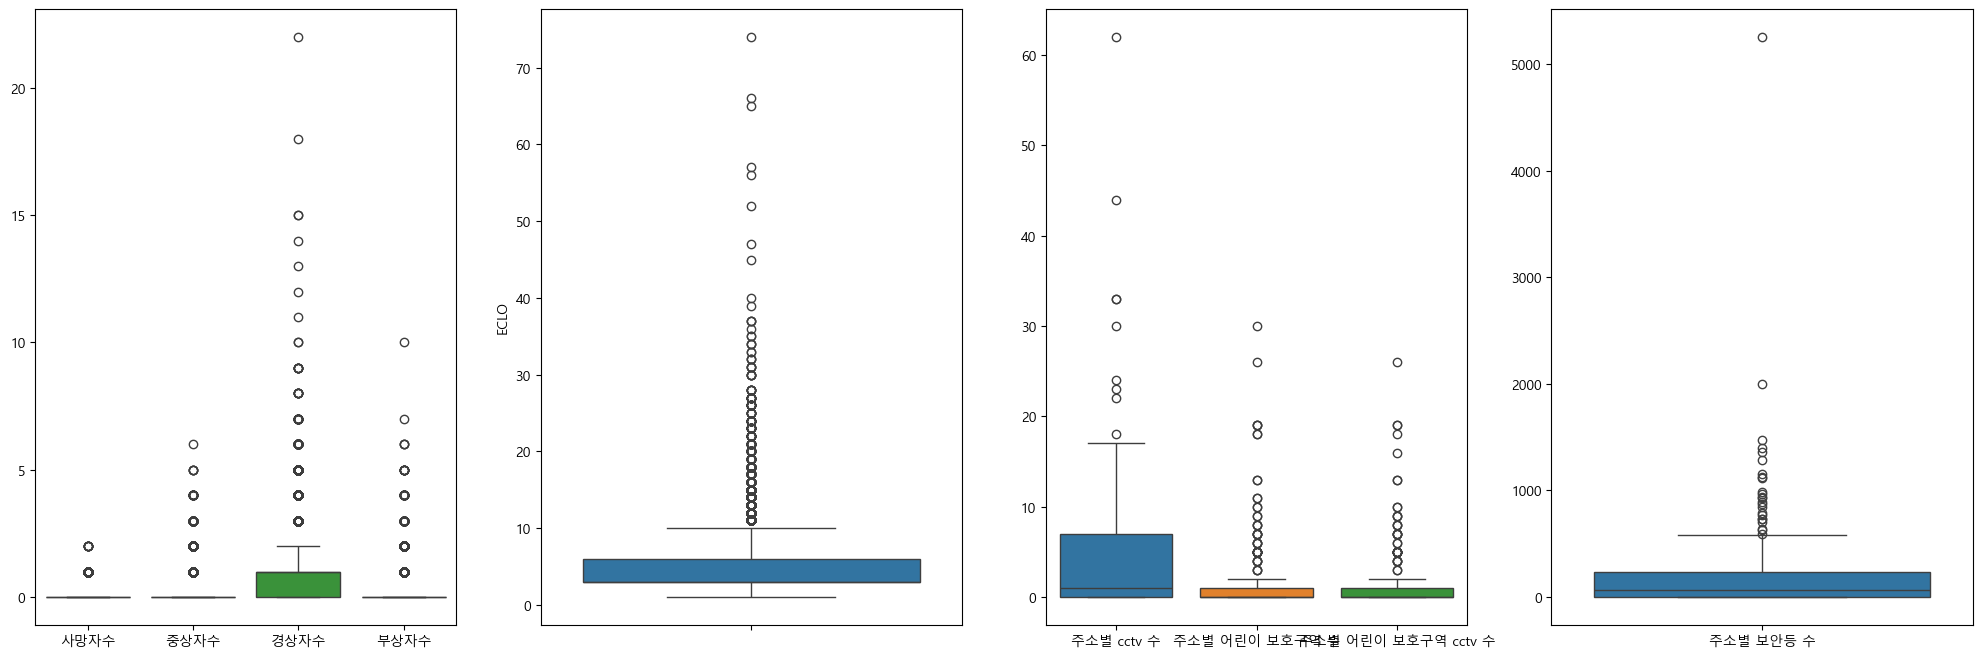

In [64]:
# 숫자 컬럼의 box-plot

fig, axes = plt.subplots(figsize=(25,8), nrows=1, ncols=4)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

add_infra = df_train_join.groupby("시군구")[["주소별 cctv 수", "주소별 어린이 보호구역 수",'주소별 어린이 보호구역 cctv 수','주소별 보안등 수']].mean()

sns.boxplot(df_train_join.select_dtypes("number").iloc[:,0:4], ax=axes[0])
sns.boxplot(df_train_join.select_dtypes("number").iloc[:,4], ax=axes[1])
sns.boxplot(add_infra[["주소별 cctv 수", "주소별 어린이 보호구역 수",'주소별 어린이 보호구역 cctv 수']], ax=axes[2])
sns.boxplot(add_infra[['주소별 보안등 수']], ax=axes[3])

plt.show()

"사망" 이란 교통사고 발생시로부터 30일이내에 사망한 경우. (99년까지는 72시간 이내)  
"중상" 이란 교통사고로 인하여 3주 이상의 치료를 요하는 부상을 입은 경우.  
"경상" 이란 교통사고로 인하여 5일 이상 3주 미만의 치료를 요하는 부상을 입은 경우.  
"부상신고" 란 교통사고로 인하여 5일 미만의 치료를 요하는 부상을 입은 경우.  

---

사고에 따른 피해자 수를 살펴보면,  
  
사고에 따라 부상의 경우가 다르기 때문에 대부분의 값이 0인 경우를 알 수 있음(그렇기 때문에 피해자 수가 Q3 + 1.5iqr을 벗어나는 값이 많아 보임).  
  
그러나 차량의 수용 인원이나 주위의 유동 인구, 사고의 규모에 따라 피해자의 수가 달라짐을 확인할 수 있다.  
  
경상자의 경우 20명이 넘는 피해자가 있는 경우도 있는데, 아마 추돌 사고나 버스 등에 대형 차량에 의한 사고로 보인다.  
  
**ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1**  
  
ECLO 식은 위와 같은데,  
  
데이터 분포의 75%까지 10의 값인 것을 유추해보면  
  
사망자 1명 또는 중상자 2명, 경상자 3명, 부상자 10명 등으로 생각할 수 있다.  
  
부상과 경상까지 생각한다면 75% 정도가 큰 사고가 아님을 알 수 있지만,  
  
사망과 중상만으로도 ECLO 값이 10을 초과할 수 있기 때문에  
  
적어도 25% 사고는 절대 가볍다고 생각할 수 없는 사고일 것이다.

---

교통 사고 예방을 위한 인프라의 수를 살펴봤을 때,  
  
대부분은 좌로 치우친 그래프를 확인할 수 있는데 이는 각 지역의 인구수나 소득 수준에 비례할 것이라고 생각한다.  
  
인구 수에 비례한다고 했을 때 인구 밀도가 높지 않은 지역 혹은, 차량의 유입이 없는 지역은 cctv가 없을 가능성이 크다.

---

object 타입의 데이터 분포를 시각화 하기 전에 사고 일시를 월과 시간대로 나눠  
  
계절과 시간대를 구분하려고 한다.

In [76]:
# 사고 일시를 월과 시각으로 분리

df_train_join["사고일시"] = pd.to_datetime(df_train_join["사고일시"], format="%Y-%m-%d %H:%M:%S")

df_train_join["사고 월"] = df_train_join["사고일시"].dt.strftime("%m").astype(int)
df_train_join["사고 시각"] = df_train_join["사고일시"].dt.strftime("%H").astype(int)

df_train_join[["사고일시", "사고 월", "사고 시각"]]

,사고일시,사고 월,사고 시각
0,2019-01-01 00:00:00,1,0
1,2019-01-01 00:00:00,1,0
2,2019-01-01 01:00:00,1,1
3,2019-01-01 02:00:00,1,2
4,2019-01-01 04:00:00,1,4
...,...,...,...
39604,2021-12-31 19:00:00,12,19
39605,2021-12-31 19:00:00,12,19
39606,2021-12-31 21:00:00,12,21
39607,2021-12-31 22:00:00,12,22


In [77]:
# 분리된 월과 시각을 계절과 시간대로 변경

df_train_join["사고 계절"] = 0
df_train_join["사고 시간대"] = 0

for r in range(df_train_join.shape[0]) : 

    # 각 사고 월을 계절로 치환
    if (df_train_join.loc[r,"사고 월"] >= 3) & (df_train_join.loc[r,"사고 월"] < 6) : 
        df_train_join.loc[r,"사고 계절"] = "봄"
    elif (df_train_join.loc[r,"사고 월"] >= 6) & (df_train_join.loc[r,"사고 월"] < 9) : 
        df_train_join.loc[r,"사고 계절"] = "여름"
    elif (df_train_join.loc[r,"사고 월"] >= 9) & (df_train_join.loc[r,"사고 월"] < 12) : 
        df_train_join.loc[r,"사고 계절"] = "가을"
    else : 
        df_train_join.loc[r,"사고 계절"] = "겨울"

    
    # 각 사고 시각을 시간대로 치환
    if (df_train_join.loc[r,"사고 시각"] >= 0) & (df_train_join.loc[r,"사고 시각"] < 6) : 
        df_train_join.loc[r,"사고 시간대"] = "새벽"
    elif (df_train_join.loc[r,"사고 시각"] >= 6) & (df_train_join.loc[r,"사고 시각"] < 12) : 
        df_train_join.loc[r,"사고 시간대"] = "아침"
    elif (df_train_join.loc[r,"사고 시각"] >= 12) & (df_train_join.loc[r,"사고 시각"] < 18) : 
        df_train_join.loc[r,"사고 시간대"] = "점심"
    else : 
        df_train_join.loc[r,"사고 시간대"] = "저녁"

df_train_join[["사고일시", "사고 월", "사고 시각","사고 계절","사고 시간대"]]

,사고일시,사고 월,사고 시각,사고 계절,사고 시간대
0,2019-01-01 00:00:00,1,0,겨울,새벽
1,2019-01-01 00:00:00,1,0,겨울,새벽
2,2019-01-01 01:00:00,1,1,겨울,새벽
3,2019-01-01 02:00:00,1,2,겨울,새벽
4,2019-01-01 04:00:00,1,4,겨울,새벽
...,...,...,...,...,...
39604,2021-12-31 19:00:00,12,19,겨울,저녁
39605,2021-12-31 19:00:00,12,19,겨울,저녁
39606,2021-12-31 21:00:00,12,21,겨울,저녁
39607,2021-12-31 22:00:00,12,22,겨울,저녁


In [81]:
object_select = df_train_join.select_dtypes("object").drop(["ID"], axis=1)

object_select

,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사고 계절,사고 시간대
0,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,겨울,새벽
1,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,겨울,새벽
2,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,겨울,새벽
3,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,겨울,새벽
4,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,겨울,새벽
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,여,52세,상해없음,이륜,남,28세,경상,겨울,저녁
39605,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,상해없음,승용,남,52세,경상,겨울,저녁
39606,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,중상,승용,남,73세,중상,겨울,저녁
39607,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,40세,상해없음,승용,여,57세,경상,겨울,저녁


object 타입의 히스토그램을 살펴보면

<function matplotlib.pyplot.show(close=None, block=None)>

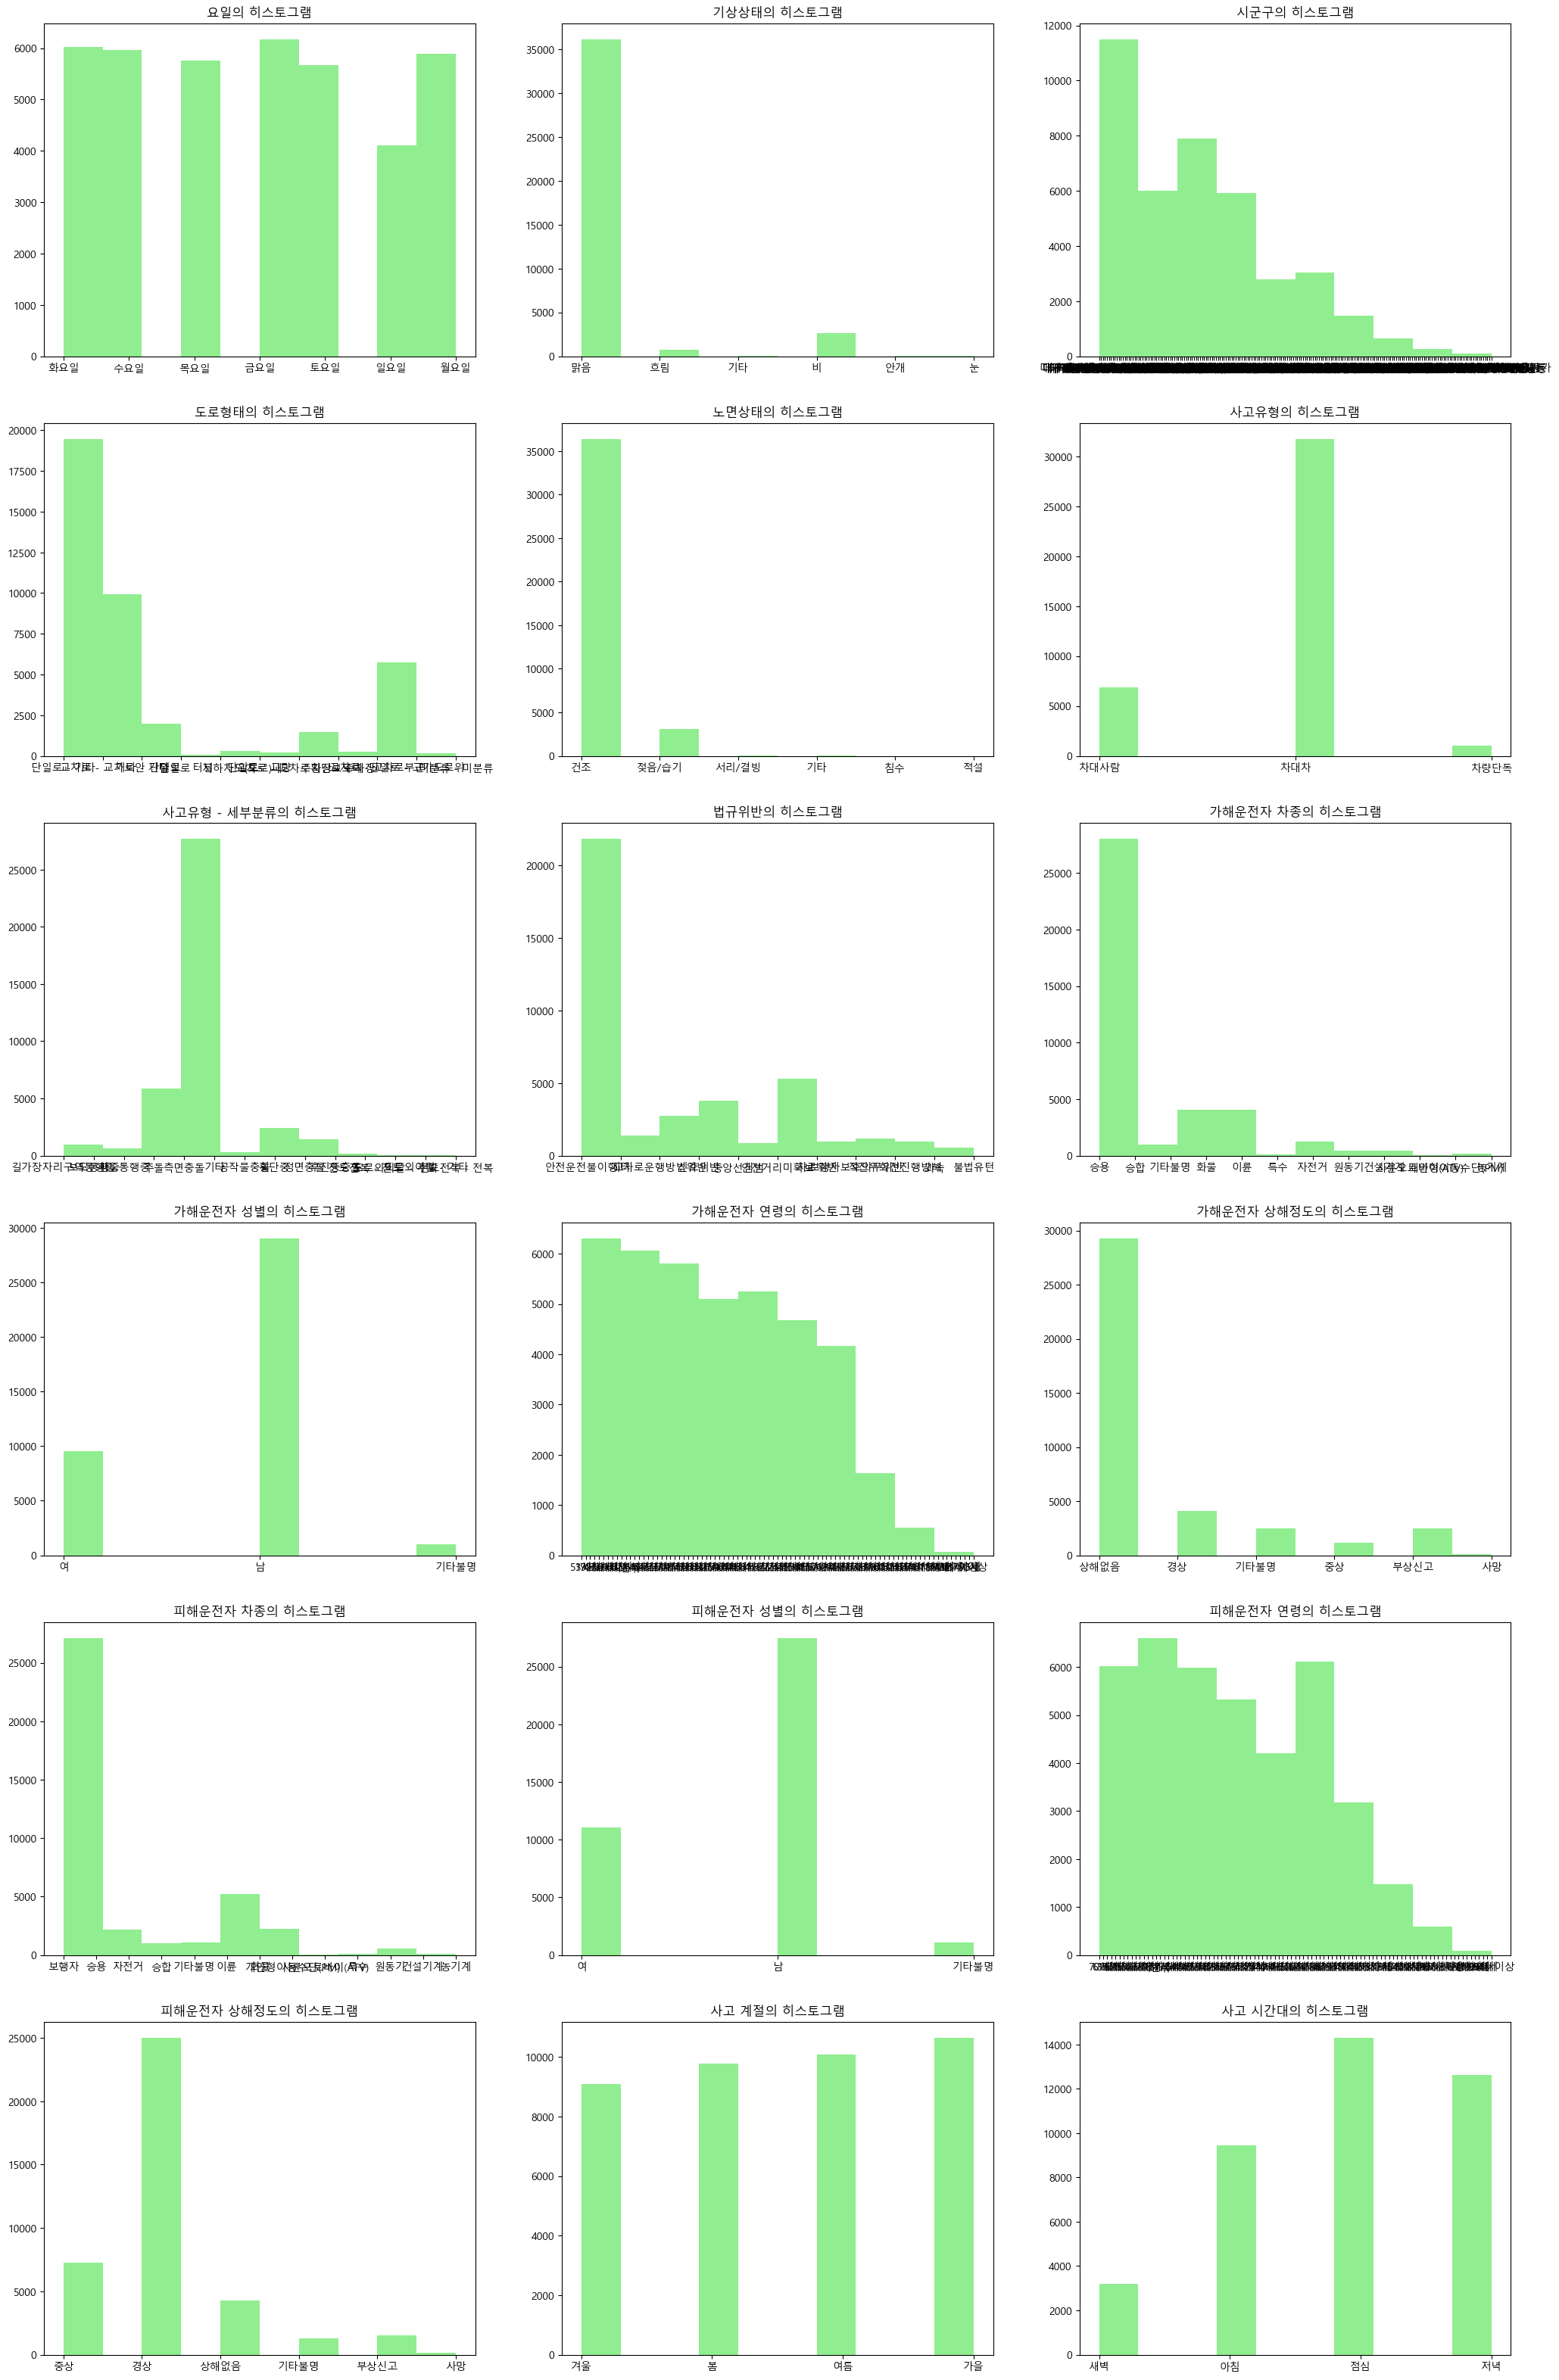

In [86]:
fig, axes = plt.subplots(figsize=(25,40), nrows=6, ncols=3)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

col_ob_sel = object_select.columns

for L in range(len(col_ob_sel)) : 
    ax = axes[L//3][L%3]

    ax.hist(object_select.iloc[:,L], color="lightgreen", align="mid")
    ax.set_title(col_ob_sel[L]+"의 히스토그램")

plt.show

겹쳐서 안 보이는 그래프는 따로 보도록 하고  
  
하나하나 살펴보면  
  
- 요일 : 일요일을 제외하면, 요일에 따른 사고는 큰 차이가 없어 보임
- 기상 상태 : 날씨가 안 좋을 때보다 날씨가 좋을 때 사고가 많이 일어남 >> 날씨가 안 좋아서 더욱 조심 or 날씨가 맑을 때 교통량이 많음
- 노면 상태 : 건조할 때 사고가 많음 >> 이는 기상 상태와 연관성을 보이므로 둘 중 하나의 변수 제거 고려
- 사고 유형 : '차대차'가 가장 많음
- 가해 운전자 차종 : 업무용 차보다 승용차가 압도적으로 많음 ↔ 화물이나 이륜도 어느 정도 비율을 차지
- 피해 운전자 차종 : 사고 유형이 차대차가 많은데, 피해 운전자 차종은 '보행자'가 많음 >> 데이터의 모순이 존재
- 가해 운전자 / 피해 운전자 성별 : 남자가 많음 >> 해당 도시에 운전 면허를 가진 사람이 남자가 많을 가능성 ↔ 여성이 운전을 조금 더 조심하게 할 가능성
- 가해 운전자 / 피해 운전자 상해 정도 : 가해 운전자는 상해가 없을 수 있으나 피해 운전자는 경상을 입은 경우가 많음
- 사고 계절 : 계절별 큰 차이는 없으나, 가을이 가장 많고 겨울이 적은 것을 봤을 때 교통량의 차이로 보임
- 사고 시간대 : 새벽이 제일 적고 점심이 제일 많은 것으로 보아 교통량의 차이로 보임

In [90]:
df_train_join["사고유형 - 세부분류"].value_counts()

사고유형 - 세부분류
측면충돌          17104
기타            10630
추돌             5885
횡단중            2443
정면충돌            837
차도통행중           616
후진중충돌           613
보도통행중           524
길가장자리구역통행중      467
공작물충돌           324
전도전복 - 전도       144
전도전복 - 전복        10
도로외이탈 - 추락        8
도로외이탈 - 기타        4
Name: count, dtype: int64

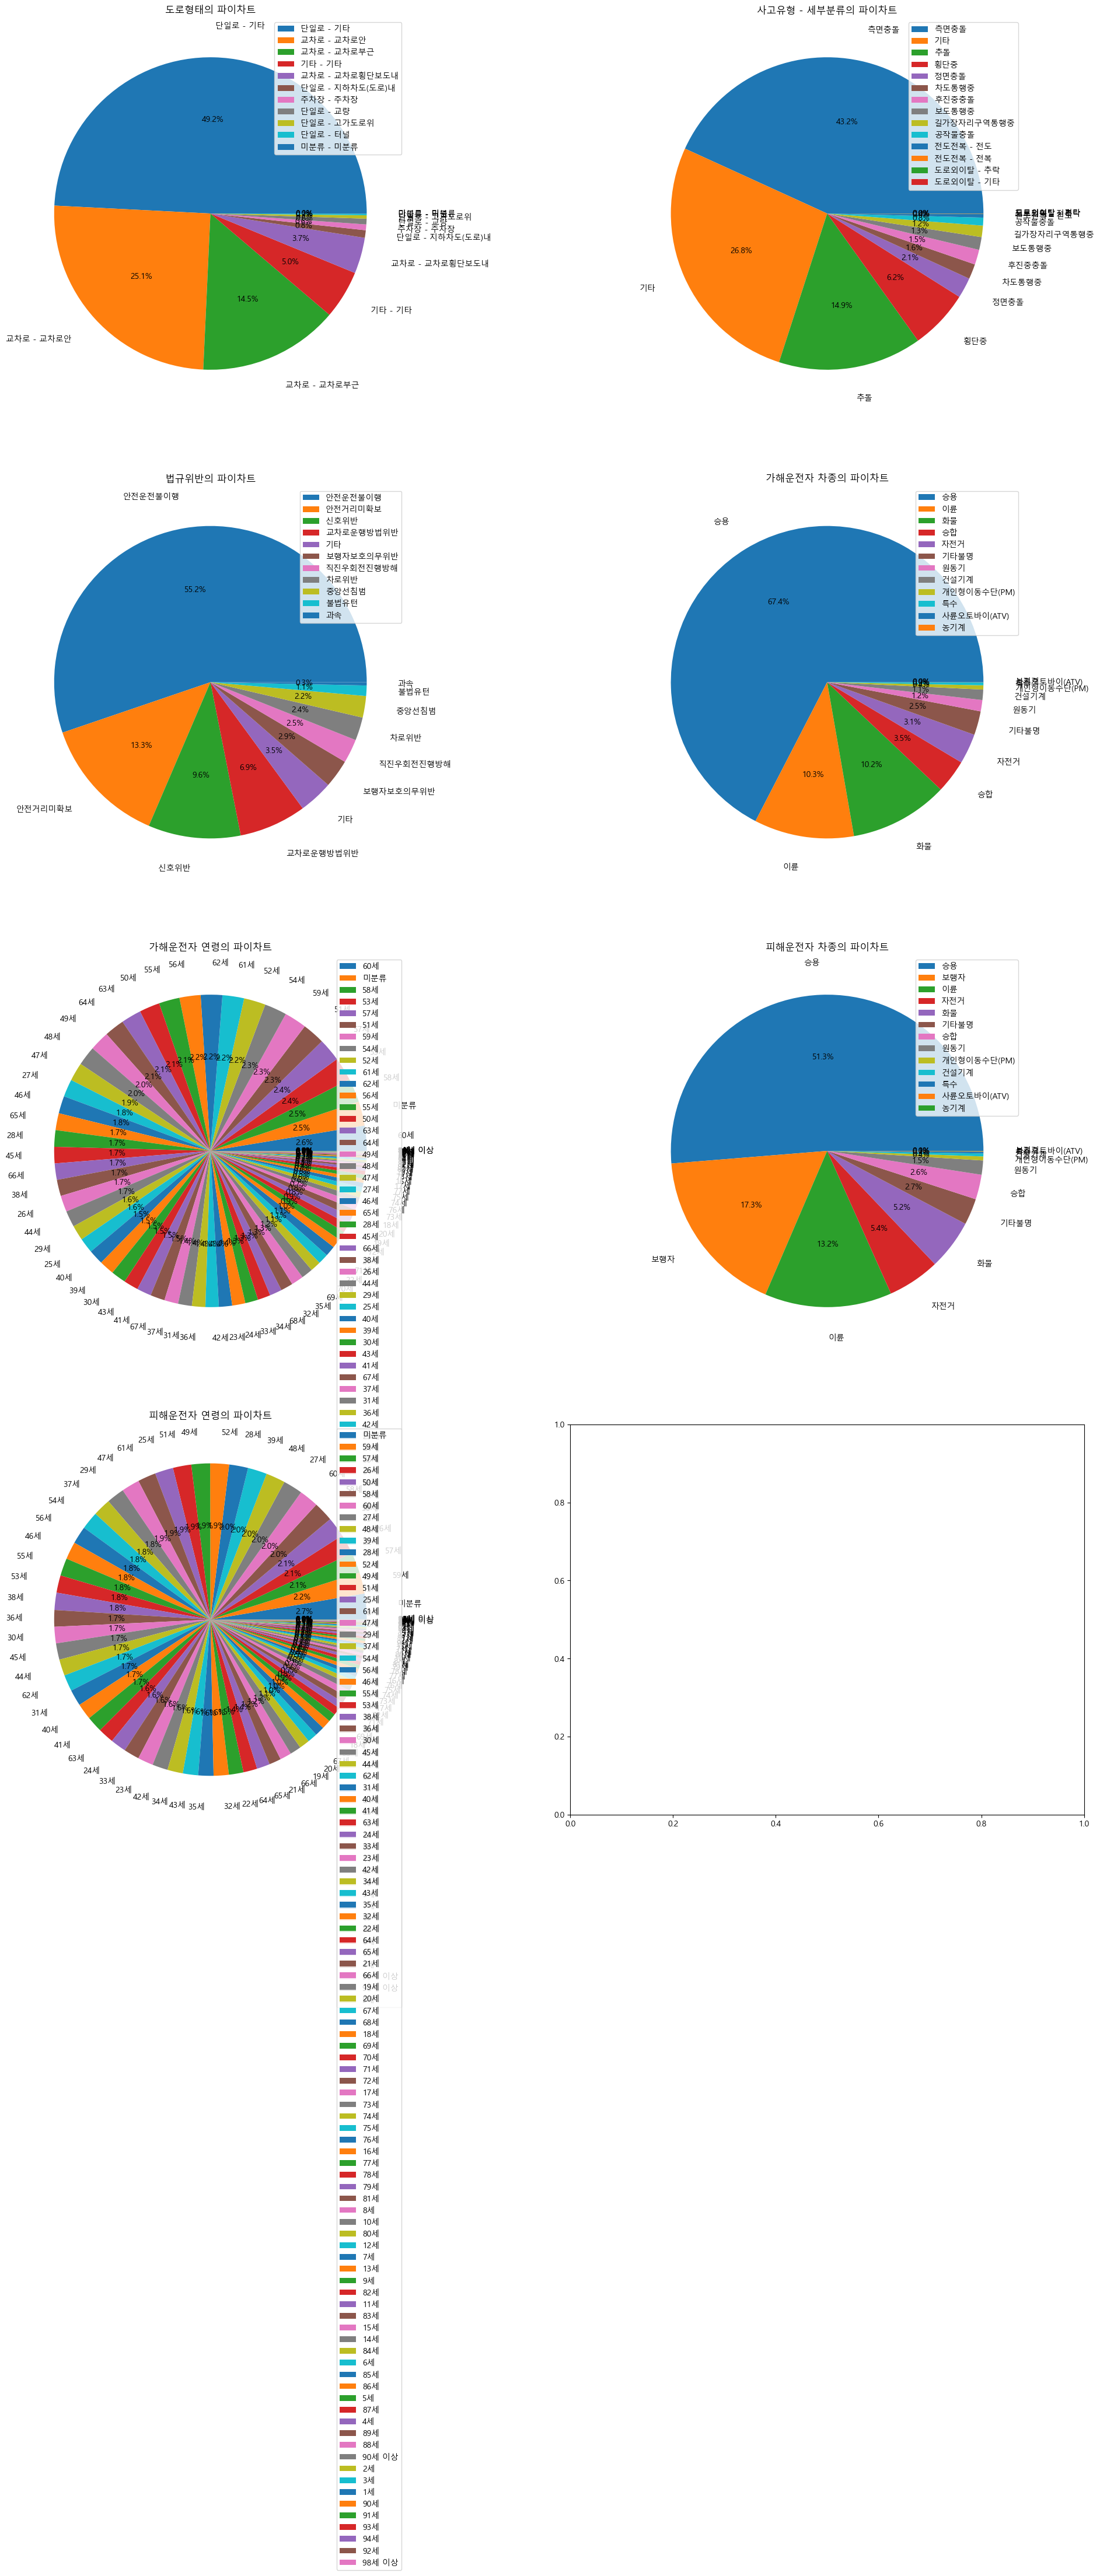

In [97]:
fig, axes = plt.subplots(figsize=(25,40), nrows=4, ncols=2)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

col_ob_sel = object_select.columns

List_pie = ['도로형태', '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 연령', '피해운전자 차종', '피해운전자 연령']

for L in range(len(List_pie)) : 
    ax = axes[L//2][L%2]

    val_cnt = df_train_join[List_pie[L]].value_counts()

    ax.pie(val_cnt, labels=val_cnt.index, labeldistance=1.2, autopct="%.1f%%")
    ax.set_title(List_pie[L]+"의 파이차트")
    ax.legend(loc="upper right")

plt.show()

### 연습

In [7]:
# 좌표 정의

x1, y1 = 1,2
x2, y2 = 2,2
x3, y3 = 2,3
x4, y4 = 1,3

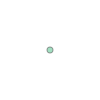

In [13]:
point = Point([x1, y1])
point

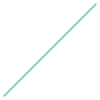

In [14]:
line = LineString([(x1,y1),(x3,y3)])
line

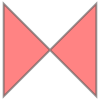

In [10]:
Polygon([(x2,y2),(x3,y3),(x1,y1),(x4,y4)])

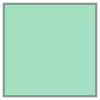

In [15]:
polygon = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)])
polygon

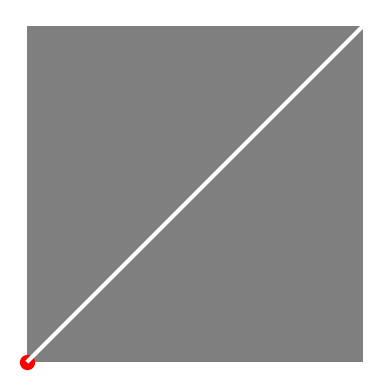

Point
LineString
Polygon


In [19]:
# 공간데이터 시각화

ax = gpd.GeoSeries(polygon).plot(color='black', alpha=0.5)

gpd.GeoSeries(line).plot(ax=ax, linewidth=3, color='white')

gpd.GeoSeries(point).plot(ax=ax, color="red", markersize=100)

plt.axis("off")

plt.show()

print(point.geom_type)
print(line.geom_type)
print(polygon.geom_type)